# __Recurrent Neural Network (RNN)__

Recurrent neural networks (RNNs) stand out as a specialized form of neural network. Unlike other neural networks, RNNs introduce a unique mechanism leveraging the output of preceding steps as input for the current step within a sequence. This integration, facilitated by what's termed a hidden state, furnishes RNNs with the invaluable capacity to retain memory of past inputs. Such memory retention proves instrumental in capturing temporal dependencies inherent in sequential data, rendering RNNs indispensable for a broad spectrum of applications spanning natural language processing, speech recognition, and beyond.

In [139]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)
from tensorflow.keras.layers import (
    Embedding, 
    SimpleRNN, 
    Flatten, 
    Dense, 
    Dropout
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# Custom libraries
import sys
sys.path.append('..')
from functions.models import *

First, we will load the datasets that have already been preprocessed.

In [140]:
train_path = '../data/X_train.tsv'
test_path = '../data/X_test.tsv'
validation_path = '../data/X_val.tsv'

X_train = pd.read_csv(train_path, sep='\t')
X_test = pd.read_csv(test_path, sep='\t')
X_val = pd.read_csv(validation_path, sep='\t')

In [141]:
train_path = '../data/y_train.tsv'
test_path = '../data/y_test.tsv'
validation_path = '../data/y_val.tsv'

y_train = pd.read_csv(train_path, sep='\t')
y_test = pd.read_csv(test_path, sep='\t')
y_val = pd.read_csv(validation_path, sep='\t')

### Tokenization, Padding and Sequencing

In the realm of natural language processing (NLP), tokenization stands as the pivotal process of segmenting a text into smaller entities, which could be words, characters, or even groups of words termed n-grams. Each unit is then assigned an index to represent it. This allows us to transform a piece of text into a sequence of numbers that a machine learning model can understand.

In [142]:
# Define tokenizer
tokenizer = Tokenizer()
# Fit tokenizer on training data
tokenizer.fit_on_texts(X_train['comment'])

Indexes of each token:

In [143]:
tokenizer.word_index

{'name': 1,
 'like': 2,
 'love': 3,
 'would': 4,
 'get': 5,
 'one': 6,
 'good': 7,
 'people': 8,
 'thanks': 9,
 'really': 10,
 'lol': 11,
 'know': 12,
 'thank': 13,
 'think': 14,
 'time': 15,
 'make': 16,
 'thing': 17,
 'see': 18,
 'hope': 19,
 'sorry': 20,
 'much': 21,
 'got': 22,
 'going': 23,
 'want': 24,
 'year': 25,
 'still': 26,
 'look': 27,
 'feel': 28,
 'even': 29,
 'well': 30,
 'right': 31,
 'go': 32,
 'oh': 33,
 'cannot': 34,
 'bad': 35,
 'guy': 36,
 'yeah': 37,
 'could': 38,
 'never': 39,
 'game': 40,
 'way': 41,
 'need': 42,
 'u': 43,
 'day': 44,
 'happy': 45,
 'man': 46,
 'great': 47,
 'better': 48,
 'say': 49,
 'actually': 50,
 'glad': 51,
 'also': 52,
 'sure': 53,
 'someone': 54,
 'back': 55,
 'though': 56,
 'something': 57,
 'best': 58,
 'wow': 59,
 'work': 60,
 'thought': 61,
 'take': 62,
 'yes': 63,
 'hate': 64,
 'mean': 65,
 'pretty': 66,
 'always': 67,
 'wish': 68,
 'made': 69,
 'life': 70,
 'help': 71,
 'post': 72,
 'first': 73,
 'fuck': 74,
 'haha': 75,
 'find': 7

Once we have tokenized our text, we need to use the generated tokens to convert the headlines into sequences:

In [144]:
train_sequences = tokenizer.texts_to_sequences(X_train["comment"])
test_sequences = tokenizer.texts_to_sequences(X_test["comment"])
val_sequences = tokenizer.texts_to_sequences(X_val["comment"])

Original headlines

In [145]:
X_train["comment"].values.tolist()[:3]

['fuck', 'make feel threatened', 'dirty southern wanker']

Sequences of tokens:

In [146]:

# Sequences
train_sequences[:3]

[[74], [16, 28, 3201], [1252, 3202, 5002]]

As it can be noticed, since each headline has a different length, each sequence has also a different length. However, in order to feed the data into the neural network, all the sequences must have the same length. Therefore, we will need to apply some kind of transformation to these sequences to make them all have the same length. For doing so, we will apply a technique called padding which adds zeros in order to have all the sequences with the same length.

In [147]:
max_seq_len = max([len(seq) for seq in train_sequences])

In [148]:
train_padded = pad_sequences(train_sequences, maxlen=max_seq_len, padding="post")
val_padded = pad_sequences(val_sequences, maxlen=max_seq_len, padding="post")

In [149]:
# Sequences after padding
train_padded[:3]

array([[  74,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  16,   28, 3201,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [1252, 3202, 5002,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]])

### Model Building

In [150]:
vocab_size = len(tokenizer.word_index) + 1

A recurrent neural network (RNN) model has been designed in Keras with the following layers:

+ Embedding Layer: Converts word indices into dense vectors.
+ SimpleRNN Layers: Four SimpleRNN layers with 32 hidden units each, three of which return sequences.
+ Flatten Layer: Flattens the output to connect to dense layers.
+ Dropout Layer: Helps prevent overfitting by turning off 20% of the units.
+ Dense Layers: A dense layer with 64 units and ReLU activation, followed by an output dense layer with sigmoid activation for binary classification.


This model should be suitable for sequential data such as text or time series. The combination of Embedding and SimpleRNN layers allows capturing sequential relationships and dependencies in the input data, while the dense layers provide the capability to learn more abstract representations and perform the final classification. The use of Dropout helps regularize the model and prevent overfitting during training.

In [151]:
max_features = vocab_size  
maxlen = max_seq_len  

model = Sequential()
model.add(Embedding(max_features, 100))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.

# Flatten and Dense Layer
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))

model.add(Dense(1, activation="sigmoid"))

In [152]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

### Model Training

In [153]:
history = model.fit(train_padded, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(val_padded, np.array(y_val)))

Epoch 1/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - acc: 0.0641 - loss: -1050.0887 - val_acc: 0.0624 - val_loss: -9192.8271
Epoch 2/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - acc: 0.0623 - loss: -14742.2188 - val_acc: 0.0624 - val_loss: -35172.1641
Epoch 3/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - acc: 0.0611 - loss: -44628.0312 - val_acc: 0.0624 - val_loss: -74895.5312
Epoch 4/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - acc: 0.0630 - loss: -87884.3672 - val_acc: 0.0624 - val_loss: -126492.5000
Epoch 5/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - acc: 0.0604 - loss: -143525.2656 - val_acc: 0.0624 - val_loss: -188621.3438
Epoch 6/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - acc: 0.0620 - loss: -207483.4375 - val_acc: 0.0624 - val_loss: -260239.6562
Epoch 7/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - acc: 0.0627 - loss: -280771.8125 - val_acc: 0.0624 - val_loss: -340882.2188
Epoch 8/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - acc: 0.0622 - loss: -365191.1

### Model Validation

In [154]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

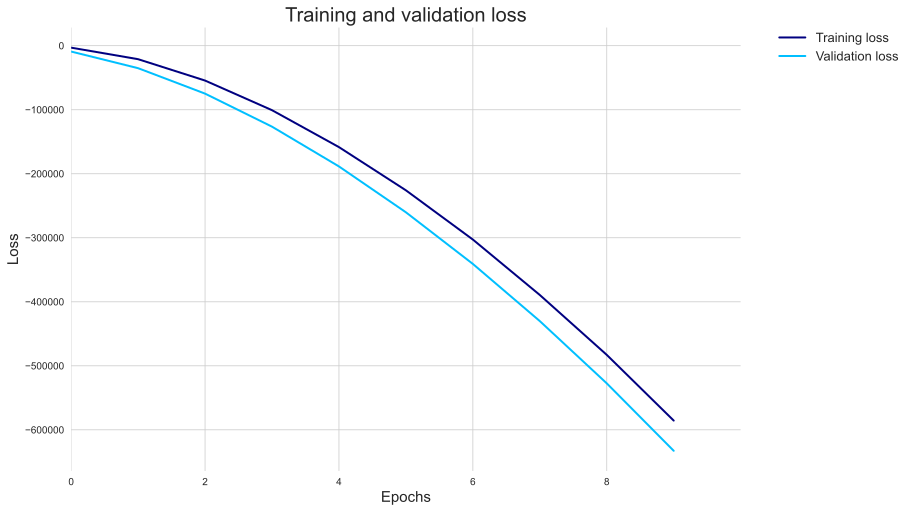

In [155]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "navy", "deepskyblue", "Loss", 2)

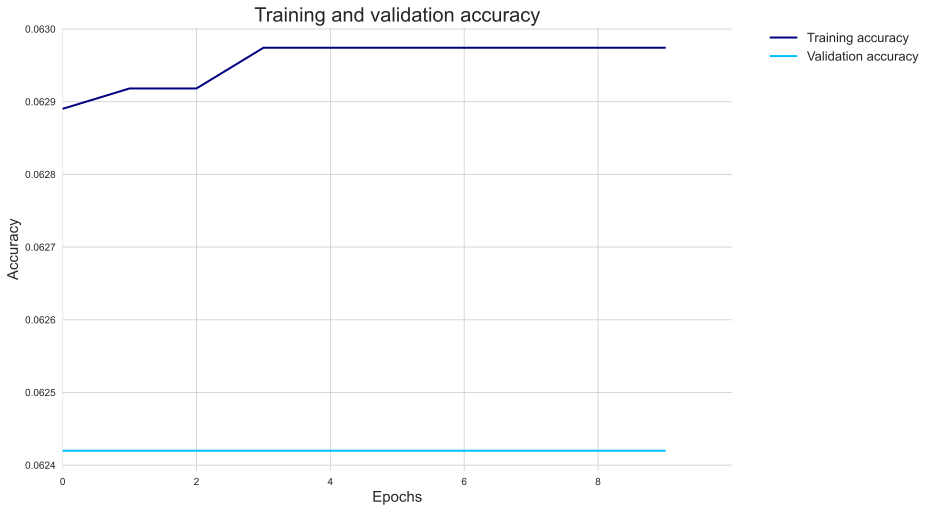

In [156]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "navy", "deepskyblue", "Accuracy", 2)


Based on the observed training results, it can be concluded that the model did not effectively learn the underlying patterns in the data during the training process. The rapid increase in training loss and low accuracies (around 0.06) indicate that the model struggled to capture meaningful relationships between the input data and the target labels.